## Recommendation with User Ratings (Explicit Feedback)

We focus on the rating prediction recommendation task with explicit feedback. We will:

* load and process the MovieLens 1M dataset,
* build a baseline estimation model,
* build a collaborative filtering model,
* build a matrix factorization model,
* and try to improve upon these models.

First, we need to load and preprocess the experiment dataset. We use the MovieLens 1M data from https://grouplens.org/datasets/movielens/1m/ in this homework. The code has been provided in the next cell, and you need to run it. The resulting data variables are: train_mat is the numpy array variable for training data of size (#users, #items) with non-zero entries representing user-item ratings, and zero entries representing unknown user-item ratings; and test_mat is the numpy array variable for testing data of size (#users, #items).

In [ ]:
# if you're using colab, this is a clunky way to load the ratings.dat file we need
# navigate in your finder to ratings.dat when asked
from google.colab import files
uploaded = files.upload()

Saving ratings.dat to ratings.dat


In [ ]:
import io
import pandas as pd
import numpy as np
import sklearn
from scipy.sparse import coo_matrix

data_df = pd.read_csv(io.BytesIO(uploaded['ratings.dat']), sep='::', names=["UserID", "MovieID", "Rating", "Timestamp"])

# if you are running this notebook locally, you can replace above with something like this:
# data_df = pd.read_csv('./ratings.dat', sep='::', names=["UserID", "MovieID", "Rating", "Timestamp"])

# First, generate dictionaries for mapping old id to new id for users and movies
unique_MovieID = data_df['MovieID'].unique()
unique_UserID = data_df['UserID'].unique()
j = 0
user_old2new_id_dict = dict()
for u in unique_UserID:
    user_old2new_id_dict[u] = j
    j += 1
j = 0
movie_old2new_id_dict = dict()
for i in unique_MovieID:
    movie_old2new_id_dict[i] = j
    j += 1

# Then, use the generated dictionaries to reindex UserID and MovieID in the data_df
user_list = data_df['UserID'].values
movie_list = data_df['MovieID'].values
for j in range(len(data_df)):
    user_list[j] = user_old2new_id_dict[user_list[j]]
    movie_list[j] = movie_old2new_id_dict[movie_list[j]]
data_df['UserID'] = user_list
data_df['movieID'] = movie_list

# generate train_df with 70% samples and test_df with 30% samples, and there should have no overlap between them.
train_index = np.random.random(len(data_df)) <= 0.7
train_df = data_df[train_index]
test_df = data_df[~train_index]

# generate train_mat and test_mat
num_user = len(data_df['UserID'].unique())
num_movie = len(data_df['MovieID'].unique())

train_mat = coo_matrix((train_df['Rating'].values, (train_df['UserID'].values, train_df['MovieID'].values)), shape=(num_user, num_movie)).astype(float).toarray()
test_mat = coo_matrix((test_df['Rating'].values, (test_df['UserID'].values, test_df['MovieID'].values)), shape=(num_user, num_movie)).astype(float).toarray()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


## Build the Baseline Estimation Model

First, let's implement a simple personalized recommendation model -- the baseline estimate -- introduced in class: $b_{u,i}=\mu+b_i+b_u$, where $\mu$ is the overall mean rating for all items, $b_u$ = average rating of user $u-\mu$, $b_i$ = average rating of item $i-\mu$. Store your prediction as a numpy array variable 'prediction_mat' of size (#users, #movies) with each entry showing the predicted rating for the corresponding user-movie pair.

* Hint: for users who do not have ratings in train_mat, set $b_u=0$ for them; and for movies which do not have ratings in train_mat, set $b_i=0$ for them

In [ ]:
# calculate the prediction_mat by the baseline estimation recommendation algorithm
# Your Code Here..
total_non_zero = np.sum(train_mat)
total_non_zero_count = np.count_nonzero(train_mat)
overall_mean = total_non_zero/total_non_zero_count
print(overall_mean)

#sum of cols of train_mat
colsum = np.matmul(train_mat, (np.ones(train_mat.shape[1])).reshape(-1,1))
nonzero_count_cols = np.zeros(train_mat.shape[0])
j=0
for row in train_mat:
  nonzero_count_cols[j] = np.count_nonzero(row)
  j=j+1

user_avg_rating = np.zeros(train_mat.shape[0])
for i in range(train_mat.shape[0]):
  if(nonzero_count_cols[i]>0):
    user_avg_rating[i] = colsum[i]/nonzero_count_cols[i]


#sum of rows of train_mat
rowsum = np.matmul((np.ones(train_mat.shape[0])).reshape(1,-1), train_mat)
nonzero_count_rows = np.zeros(train_mat.shape[1])


3.5816168552388405


In [ ]:
j=0
for row in np.transpose(train_mat):
  nonzero_count_rows[j] = np.count_nonzero(row)
  j=j+1
rowsum = np.transpose(rowsum)
movie_avg_rating = np.zeros(train_mat.shape[1])
for i in range(train_mat.shape[1]):
  if(nonzero_count_rows[i]>0):
    movie_avg_rating[i] = rowsum[i]/nonzero_count_rows[i]

In [ ]:
row_indices = []
col_indices = []
predictions = []
for row in range(train_mat.shape[0]):
  for col in range(train_mat.shape[1]):
    if(train_mat[row,col]== 0):
      row_indices.append(row)
      col_indices.append(col)
      if(user_avg_rating[row] == 0):
        bu = 0
      else:
        bu = user_avg_rating[row] - overall_mean
      if(user_avg_rating[col] == 0):
        bm = 0
      else:
        bm = movie_avg_rating[col] - overall_mean
      pred = overall_mean + bu + bm
      predictions.append(pred)

baseline_prediction_mat = coo_matrix((np.array(predictions), (np.array(row_indices), np.array(col_indices))), shape=(num_user, num_movie)).astype(float).toarray()

Now, with this prediction_mat based on the baseline estimate, let's calculate the RMSE to evaluate the quality of the baseline estimate model. Please print out the RMSE of your prediction_mat using test_mat in the next cell.


In [ ]:
# calculate and print out the RMSE for your prediction_df and the test_df
# Your Code Here...
rmse = 0
count = 0
for i in range(len(row_indices)):
  if(test_mat[row_indices[i],col_indices[i]]!=0):
    rmse= rmse + np.square((baseline_prediction_mat[row_indices[i],col_indices[i]]-test_mat[row_indices[i],col_indices[i]]))
    count=count+1

rmse = rmse/count
rmse = np.sqrt(rmse)
print(rmse)


0.9377966535513562


## Collaborative Filtering with Jaccard Similarity

In this part, you need to build a collaborative filtering recommendation model with **Jaccard similarity** to predict user-movie ratings.

The prediction of the score for a user-item pair $(u,i)$ should use the formulation: $p_{u,i}=\bar{r}_u+\frac{\sum_{u^\prime\in N}s(u,u^\prime)(r_{u^\prime,i}-\bar{r}_{u^\prime})}{\sum_{u^\prime\in N}|s(u, u^\prime)|}$ as introduced in class, where $s(u, u^\prime)$ is the Jaccard similarity. We set the size of $N$ as 10.

In the next cell, you need to write your code to implement this algorithm, and generate a numpy array variable named 'prediction_mat' of size (#user, #movie) with each entry showing the predicted rating for the corresponding user-movie pair.

* Hint: when you find the nearest neighbor set $N$ of a user $u$, do not include user $u$ in $N$  


In [ ]:
# calculate the prediction_mat by your user-user collaborative filtering recommendation algorithm
# Your Code Here...

#computing the jaccard similarities
binarized_train_mat = np.zeros_like(train_mat)
for i in range(train_mat.shape[0]):
  for j in range(train_mat.shape[1]):
    if(train_mat[i,j]>0):
      binarized_train_mat[i,j]=1

pred_row_indices = test_df['UserID'].values
pred_col_indices = test_df['MovieID'].values



Please print out the RMSE of your prediction_mat using test_mat in the next cell.

In [1]:
# calculate and print out the RMSE for your prediction_df and the test_df

Comparing the RMSE results of this collaborative filtering and the baseline estimate algorithm, what do you observe? Is the  collaborative filtering the one producing the best performance? What reasons do you think can explain what you observe?

In [ ]:
intersection_matrix = np.dot(binarized_train_mat, binarized_train_mat.T)

In [ ]:
colsum = np.matmul(train_mat, (np.ones(train_mat.shape[1])).reshape(-1,1))

In [ ]:
jaccard_matrix = intersection_matrix
for i in range(train_mat.shape[0]):
  for j in range(train_mat.shape[0]):
    jaccard_matrix[i,j] = intersection_matrix[i,j]/(colsum[i]+colsum[j]-intersection_matrix[i,j])


In [ ]:
row_indices = []
col_indices = []
predictions = []

for user_row in train_mat:
  for movie in user
#for i in range(len(pred_col_indices)):

  movie = pred_col_indices[i]
  #user = pred_row_indices[i]

  ru = user_avg_rating[user]
  user_jaccard_dict = {}
  for u in range(train_mat.shape[0]):
    if(user!=u):
      user_jaccard_dict[u] = jaccard_matrix[user,u]
  user_jaccard_dict = sorted(user_jaccard_dict.items(), key=lambda x: x[1], reverse=True)
  top10_similarities = np.array(user_jaccard_dict[:10]).T[1]

  #print(top10_similarities)
  nearest10_users = np.array(user_jaccard_dict[:10]).T[0]
  denom = 0
  dev_sum = 0
  for nu in nearest10_users:
    nu = int(nu)
    if(train_mat[nu,movie]!=0):
      denom += jaccard_matrix[user, nu]
      dev_sum+= jaccard_matrix[user, nu]*(train_mat[nu,movie]-user_avg_rating[nu])
  #print(denom)
  deviation = 0
  if(denom !=0):#if atleast one of the nearest neighbors has rated this movie
    deviation = dev_sum/denom
  pred = ru + deviation

  row_indices.append(user)
  col_indices.append(movie)
  predictions.append(pred)

CF_prediction_mat = coo_matrix((np.array(predictions), (np.array(row_indices), np.array(col_indices))), shape=(num_user, num_movie)).astype(float).toarray()



In [ ]:
row_indices = []
col_indices = []
predictions = []
for i in range(len(pred_col_indices)):

  movie = pred_col_indices[i]
  user = pred_row_indices[i]

  ru = user_avg_rating[user]
  user_jaccard_dict = {}
  for u in range(train_mat.shape[0]):
    if(user!=u):
      user_jaccard_dict[u] = jaccard_matrix[user,u]
  user_jaccard_dict = sorted(user_jaccard_dict.items(), key=lambda x: x[1], reverse=True)
  top10_similarities = np.array(user_jaccard_dict[:10]).T[1]

  #print(top10_similarities)
  nearest10_users = np.array(user_jaccard_dict[:10]).T[0]
  denom = 0
  dev_sum = 0
  for nu in nearest10_users:
    nu = int(nu)
    if(train_mat[nu,movie]!=0):
      denom += jaccard_matrix[user, nu]
      dev_sum+= jaccard_matrix[user, nu]*(train_mat[nu,movie]-user_avg_rating[nu])
  #print(denom)
  deviation = 0
  if(denom !=0):#if atleast one of the nearest neighbors has rated this movie
    deviation = dev_sum/denom
  pred = ru + deviation

  row_indices.append(user)
  col_indices.append(movie)
  predictions.append(pred)

CF_prediction_mat = coo_matrix((np.array(predictions), (np.array(row_indices), np.array(col_indices))), shape=(num_user, num_movie)).astype(float).toarray()



In [ ]:
rmse = 0
count = 0
for i in range(len(row_indices)):
  if(test_mat[pred_row_indices[i],pred_col_indices[i]]!=0):
    rmse= rmse + np.square((CF_prediction_mat[row_indices[i],col_indices[i]]-test_mat[row_indices[i],col_indices[i]]))
    count=count+1

rmse = rmse/count
rmse = np.sqrt(rmse)
print(rmse)

1.0712340971420589


Comparing the RMSE results of this collaborative filtering and the baseline estimate algorithm, what do you observe? Is the  collaborative filtering the one producing the best performance? What reasons do you think can explain what you observe?

**Answer:** RMSE of baseline estimate algorithm is lower than that of collaborative filtering. Thus, in this case, Baseline estimate algorithm gives the best performance. This could be due to fewer number of neighbors considered in collaborative filtering while calculating the nearest neighbors.

## Matrix Factorization

Now we turn to matrix factorization. First, let's implement the matrix factorization (MF for short) model introduced in class. The MF model can be mathematically represented as:

<center>$\underset{\mathbf{P},\mathbf{Q}}{\text{min}}\,\,L=\sum_{(u,i)\in\mathcal{O}}(\mathbf{P}_u\cdot\mathbf{Q}^\top_i-r_{u,i})^2+\lambda(\lVert\mathbf{P}\rVert^2_{\text{F}}+\lVert\mathbf{Q}\rVert^2_{\text{F}})$,</center>
    
where $\mathbf{P}$ is the user latent factor matrix of size (#user, #latent); $\mathbf{Q}$ is the movie latent factor matrix of size (#movie, #latent); $\mathcal{O}$ is a user-movie pair set containing all user-movie pairs having ratings in train_mat; $r_{u,i}$ represents the rating for user u and movie i; $\lambda(\lVert\mathbf{P}\rVert^2_{\text{F}}+\lVert\mathbf{Q}\rVert^2_{\text{F}})$ is the regularization term to overcome overfitting problem, $\lambda$ is the regularization weight (a hyper-parameter manually set by developer, i.e., you), and $\lVert\mathbf{P}\rVert^2_{\text{F}}=\sum_{x}\sum_{y}(\mathbf{P}_{x,y})^2$, $\lVert\mathbf{Q}\rVert^2_{\text{F}}=\sum_{x}\sum_{y}(\mathbf{Q}_{x,y})^2$. Such an L function is called the **loss function** for the matrix factorization model. The goal of training an MF model is to find appropriate $\mathbf{P}$ and $\mathbf{Q}$ to minimize the loss L.

To implement such an MF, here we will write a Python class for the model. There are three functions in this MF class: init, train, and predict.

* The 'init' function (**already provided**) is to initialize the variables the MF class needs, which takes 5 inputs: train_mat, test_mat, latent, lr, and reg. 'train_mat' and 'test_mat' are the corresponfing training and testing matrices we have. 'latent' represents the latent dimension we set for the MF model. 'lr' represents the learning rate, i.e., the update step in each optimization iteration, default is 0.01. 'reg' represents the regularization weight, i.e., the $\lambda$ in the MF formulation.

* The 'train' function (**partially provided and need to complete**) is to train the MF model given the training data train_mat. There is only one input to this function: an int variable 'epoch' to indicate how many epochs for training the model. The main body of this function should be a loop for 'epoch' iterations. In each iteration, following the algorithm to update the MF model:

        1. Randomly shuffle training user-movie pairs  (i.e., user-movie pairs having ratings in train_mat)
        2. Have an inner loop to iterate each user-movie pair:
                a. given a user-movie pair (u,i), update the user latent factor and movie latent factor by gradient decsent:    
<center>$\mathbf{P}_u=\mathbf{P}_u-\gamma [2(\mathbf{P}_u\cdot\mathbf{Q}_i^\top-r_{u,i})\cdot\mathbf{Q}_i+2\lambda\mathbf{P}_u]$</center>    
<center>$\mathbf{Q}_i=\mathbf{Q}_i-\gamma [2(\mathbf{P}_u\cdot\mathbf{Q}_i^\top-r_{u,i})\cdot\mathbf{P}_u+2\lambda\mathbf{Q}_i]$</center>    
<center>where $\mathbf{P}_u$ and $\mathbf{Q}_i$ are row vectors of size (1, #latent), $\gamma$ is learning rate (default is 0.01), $\lambda$ is regularization weight.</center>
        
        3. After iterating over all user-movie pairs, we have finished the training for the current epoch. Now calculate and print out the value of the loss function L after this epoch, and the RMSE on test_mat by the current MF model. Then append them to lists to keep a record of them.
The train function needs to return two lists: 'epoch_loss_list' recording the loss after each training epoch, and 'epoch_test_RMSE_list' recording the RMSE on test_mat after each training epoch.

* The 'predict' function (**already provided**) is to calculate the prediction_mat by the learned $\mathbf{P}$ and $\mathbf{Q}$.

In the next cell, we provide the 'init' and 'predict' functions. You will need to fill in the 'train' function based on the description above.

In [ ]:
class MF:
    def __init__(self, train_mat, test_mat, latent=5, lr=0.01, reg=0.01):
        self.train_mat = train_mat  # the training rating matrix of size (#user, #movie)
        self.test_mat = test_mat  # the training rating matrix of size (#user, #movie)

        self.latent = latent  # the latent dimension
        self.lr = lr  # learning rate
        self.reg = reg  # regularization weight, i.e., the lambda in the objective function

        self.num_user, self.num_movie = train_mat.shape

        self.sample_user, self.sample_movie = self.train_mat.nonzero()  # get the user-movie paris having ratings in train_mat
        self.num_sample = len(self.sample_user)  # the number of user-movie pairs having ratings in train_mat

        self.train_indicator_mat = 1.0 * (train_mat > 0)  # binary matrix to indicate whether s user-movie pair has rating or not in train_mat
        self.test_indicator_mat = 1.0 * (test_mat > 0)  # binary matrix to indicate whether s user-movie pair has rating or not in test_mat

        self.P = np.random.random((self.num_user, self.latent))  # latent factors for users, size (#user, self.latent), randomly initialized
        self.Q = np.random.random((self.num_movie, self.latent))  # latent factors for users, size (#movie, self.latent), randomly initialized

    def train(self, epoch=20, verbose=True):
        """
        Goal: Write your code to train your matrix factorization model for epoch iterations in this function
        Input: epoch -- the number of training epoch
        Output: epoch_loss_list -- a list recording the training loss for each epoch
                epoch_test_RMSE_list -- a list recording the testing RMSE after each training epoch
        """
        epoch_loss_list = []
        epoch_test_RMSE_list = []

        #train_data = []
        #for i in range(self.num_sample):#self.sample_user, self.sample_movie
        # train_data.append([self.sample_user, self.sample_movie, self.train_mat[self.sample_user, self.sample_movie]])


        test_users, test_movies = self.test_mat.nonzero()

        for ep in range(epoch):
            """
            Write your code here to implement the training process for one epoch,
            and at the end of each epoch, print out the epoch number, the training loss after this epoch,
            and the test RMSE after this epoch
            """
            #np.random.shuffle(train_data)
            shuffled = sklearn.utils.shuffle(self.sample_user, self.sample_movie)
            train_data = zip(shuffled[0],shuffled[1])
            for user,movie in train_data:
              predicted_rating = np.dot(self.P[user], (self.Q[movie]).T)
              actual_rating = train_mat[user,movie]
              Pu = self.P[user].copy()
              Qi = self.Q[movie].copy()
              self.P[user] = Pu - self.lr*(2*(predicted_rating - actual_rating)*Qi + 2*self.reg * Pu)
              self.Q[movie] = Qi - self.lr*(2*(predicted_rating - actual_rating)*Pu + 2*self.reg * Qi)

            user_ids,movie_ids=self.train_mat.nonzero()
            train_data = zip(shuffled[0],shuffled[1])
            cnt=0
            loss = 0.0
            for user,movie in train_data:
              predicted_rating = np.dot(self.P[user], (self.Q[movie]).T)
              actual_rating = train_mat[user,movie]
              loss = loss + np.square((predicted_rating - actual_rating))

            loss = loss + self.reg*(np.square(np.linalg.norm(self.P,'fro'))+np.square(np.linalg.norm(self.Q,'fro')))
            epoch_loss_list.append(loss)

            rmse = 0
            count_rmse = 0
            for test_user,test_movie in zip(test_users, test_movies):
              predicted_rating = np.dot(self.P[test_user], (self.Q[test_movie]).T)
              rmse += np.square(test_mat[test_user,test_movie]-predicted_rating)
              count_rmse += 1

            rmse = rmse/count_rmse
            rmse = np.sqrt(rmse)
            epoch_test_RMSE_list.append(rmse)
            print("Epoch {} : loss = {} , rmse = {}".format(ep+1,loss,rmse))

            """
            End of your code for this function
            """
        return epoch_loss_list, epoch_test_RMSE_list


    def predict(self):
        prediction_mat = np.matmul(self.P, self.Q.T)
        return prediction_mat

Now, let's train an MF model based on your implementation. The code is provided, you just need to excute the next cell. The expectations are:

* first, the code can be successfully excuted without error;
* and second, the training loss and RMSE on **test_mat** of each training epoch should be printed out for all 20 epochs.


* Hint: the expected time used for training is around 10s to 60s per training epoch.

In [ ]:
mf = MF(train_mat, test_mat, latent=5, lr=0.01, reg=0.001)
epoch_loss_list, epoch_test_RMSE_list = mf.train(epoch=20)

Epoch 1 : loss = 610632.6781268005 , rmse = 0.9523858170940803
Epoch 2 : loss = 596832.4097283303 , rmse = 0.9462613701552076
Epoch 3 : loss = 581530.5533247042 , rmse = 0.9387975379002145
Epoch 4 : loss = 562852.2211313038 , rmse = 0.9290190641789208
Epoch 5 : loss = 545843.1582091859 , rmse = 0.9215744966170243
Epoch 6 : loss = 533965.061170454 , rmse = 0.9157091951847153
Epoch 7 : loss = 525777.9731593326 , rmse = 0.9131509819027603
Epoch 8 : loss = 516107.32045554975 , rmse = 0.9078839395350754
Epoch 9 : loss = 512167.93378496246 , rmse = 0.9076042341352862
Epoch 10 : loss = 507783.96966931364 , rmse = 0.9056123785515824
Epoch 11 : loss = 502266.1862222134 , rmse = 0.9024023961521176
Epoch 12 : loss = 500577.3246604785 , rmse = 0.9015550277609031
Epoch 13 : loss = 498266.8227309008 , rmse = 0.900350787860001
Epoch 14 : loss = 495894.32545574283 , rmse = 0.8999658653880108
Epoch 15 : loss = 495193.52285354777 , rmse = 0.9005273504052216
Epoch 16 : loss = 495435.5013824127 , rmse = 0

In [ ]:
mf = MF(train_mat, test_mat, latent=5, lr=0.01, reg=0.001)
epoch_loss_list, epoch_test_RMSE_list = mf.train(epoch=20)

Epoch 1 : loss = 610725.1688346888 , rmse = 0.9532207377848573
Epoch 2 : loss = 597328.5930754363 , rmse = 0.9465955276213102
Epoch 3 : loss = 587222.0745829766 , rmse = 0.9431780959947338
Epoch 4 : loss = 568263.833585108 , rmse = 0.9347102118236911
Epoch 5 : loss = 550208.6872294131 , rmse = 0.9254053974105978
Epoch 6 : loss = 536548.9384664724 , rmse = 0.9178754336108788
Epoch 7 : loss = 527860.9342245904 , rmse = 0.9151364739564599
Epoch 8 : loss = 520064.03971461643 , rmse = 0.9109705619186451
Epoch 9 : loss = 512226.6834627098 , rmse = 0.9066702297402246
Epoch 10 : loss = 507949.39824121067 , rmse = 0.9056170168144345
Epoch 11 : loss = 503215.19512651884 , rmse = 0.9023708830570486
Epoch 12 : loss = 501159.99106498744 , rmse = 0.9030737616109111
Epoch 13 : loss = 497810.0072017624 , rmse = 0.9009584467390732
Epoch 14 : loss = 496152.5853434272 , rmse = 0.9017579138497739
Epoch 15 : loss = 496016.38082613336 , rmse = 0.9017421696964899
Epoch 16 : loss = 492219.1294369945 , rmse = 

## Tune Hyper-parameters in Matrix Factorization

In the previous part, we train an MF model with latent dimension set as 5, regularization weight as 0.001, training epoch as 20. However, it is not clear whether these are good choices or not. Hence, in this part, we will tune these hyper-parameters to train an effective model.

A most straightforward but powerful method is to grid search each hyper-parameter and find the best one based on the RMSE on test_mat. In this part, we will do the grid search for train epoch, latent dimension, and regularization weight.

#### Tune training epoch####

For training epoch, we only need to run the experiment of MF for one time, and record the test RMSE for each epoch and find the epoch that produces the best test RMSE. To visually show the change of test RMSE corresponding to the training epoch, we can plot the test RMSE for each epoch in a figure as shown in the next cell.

**Note that you need to first install the matplotlib, then you can excute the next cell**

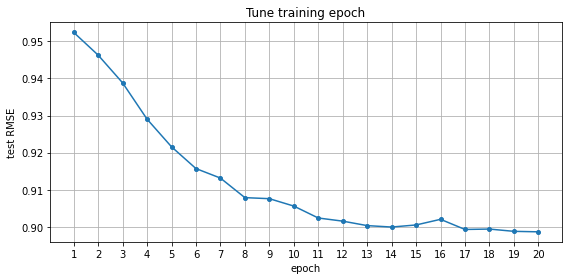

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
ax.plot(np.arange(len(epoch_test_RMSE_list)) + 1, epoch_test_RMSE_list, marker='.', linewidth=1.5, markersize=8)
ax.set_xticks(np.arange(len(epoch_test_RMSE_list)) + 1)
ax.set_ylabel('test RMSE')
ax.set_xlabel('epoch')
ax.set_title('Tune training epoch')
ax.grid(True)
plt.tight_layout()
plt.show()


Based on this plot, what is the best epoch for your MF model?

20

#### Tune latent dimension####

By this figure, you can find the best epoch for your MF model. Similarly, you can plot how the test RMSE changes when you set different latent dimensions. For this, you need to run the code to initialize and train the MF model for multiple times with different settings of 'latent'. Please run the MF model with 'latent' as {1,3,5,7,9}, and plot the corresponding test RMSE for these five different latent dimensions in the next cell.

**Note that for these five runs of experiments, record the test RMSE after E training epochs -- E is the best epoch you find by the 'Tune training epoch' plot. And here, fix regularization weight as 0.001**.

**Note that the expected output of the next cell is just the plot, you don't need to show the code and printing of the experiment with different 'latent' here.**

In [ ]:
# Your Code Here...
E=20
latents = [3,4,5,6,7,8,9]
y_axis=[]
for latent in latents:
  print("latent factors dimension : {}".format(latent))
  print("-------------------------------")
  mf = MF(train_mat, test_mat, latent=latent, lr=0.01, reg=0.001)
  epoch_loss_list, epoch_test_RMSE_list = mf.train(epoch=E)
  y_axis.append(epoch_test_RMSE_list[-1])


latent factors dimension : 3
-------------------------------
Epoch 1 : loss = 616775.1220608779 , rmse = 0.9550957997376752
Epoch 2 : loss = 605335.4536929856 , rmse = 0.9479425617151475
Epoch 3 : loss = 599348.1350875269 , rmse = 0.9451006774040026
Epoch 4 : loss = 593713.8548593894 , rmse = 0.9438051666893007
Epoch 5 : loss = 584911.6243339345 , rmse = 0.9392137433298031
Epoch 6 : loss = 573554.3896293396 , rmse = 0.9324085002975746
Epoch 7 : loss = 562494.0808563224 , rmse = 0.9266123558671865
Epoch 8 : loss = 553257.9044772537 , rmse = 0.9199856170240495
Epoch 9 : loss = 547024.004854667 , rmse = 0.916134772911125
Epoch 10 : loss = 542057.425239104 , rmse = 0.912452023755595
Epoch 11 : loss = 537809.0632974351 , rmse = 0.9086670366273634
Epoch 12 : loss = 536418.3970139247 , rmse = 0.9102369403349367
Epoch 13 : loss = 532220.0795362706 , rmse = 0.9066792354978167
Epoch 14 : loss = 531148.702714998 , rmse = 0.9069315413306355
Epoch 15 : loss = 528596.8492645338 , rmse = 0.9043566979

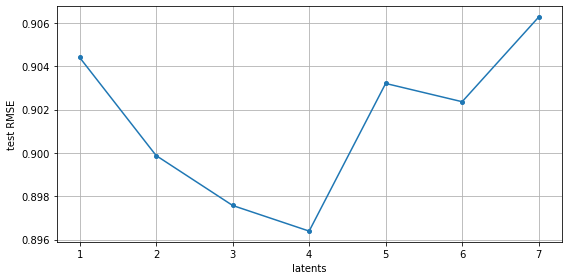

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
ax.plot(np.arange(len(y_axis)) + 1, y_axis, marker='.', linewidth=1.5, markersize=8)
ax.set_xticks(np.arange(len(y_axis)) + 1)
ax.set_ylabel('test RMSE')
ax.set_xlabel('latents')
ax.grid(True)
plt.tight_layout()
plt.show()

Based on this plot, what is the best latent dimension for your MF model?

4

#### Tune regularization weight####

Last, you can plot how the test RMSE changes when you set different regularization weight. Please run the MF model with 'reg' as {0.0001,0.0005,0.001,0.0015,0.002}, and plot corresponding test RMSE for these five different regularization weights in the next cell.

**Note that for these five runs of experiments, record the test RMSE after E training epochs -- E is the best epoch you find by the 'Tune training epoch' plot. And here, fix latent dimension as the one you find the best by the previous part**

**Note that the expected output of the next cell is just the plot, you don't need to show the code and printing of the experiment with different 'reg' here.**

In [ ]:
# Your Code Here...
import math
E=20
best_latent=4
regs = [0.0001,0.0005,0.001,0.0015,0.002]
y_axis=[]
for reg in regs:
  print("")
  print("Regularization factor : {}".format(reg))
  print("---------------------------------")
  mf = MF(train_mat, test_mat, latent=best_latent, lr=0.01, reg=reg)
  epoch_loss_list, epoch_test_RMSE_list = mf.train(epoch=E)
  y_axis.append(epoch_test_RMSE_list[-1])



Regularization factor : 0.0001
---------------------------------
Epoch 1 : loss = 613848.4757082188 , rmse = 0.9531904073643133
Epoch 2 : loss = 601377.9732770786 , rmse = 0.9468235333559275
Epoch 3 : loss = 590558.9826910507 , rmse = 0.9428333413579513
Epoch 4 : loss = 572614.217706646 , rmse = 0.9329807526050211
Epoch 5 : loss = 560632.4226694201 , rmse = 0.9260129730816455
Epoch 6 : loss = 550914.3650039686 , rmse = 0.9211814065964316
Epoch 7 : loss = 542250.9494586709 , rmse = 0.9175892028191609
Epoch 8 : loss = 535076.852409068 , rmse = 0.9136885006021196
Epoch 9 : loss = 532003.6464059674 , rmse = 0.911517460523296
Epoch 10 : loss = 529354.8845473804 , rmse = 0.912296330425892
Epoch 11 : loss = 526812.4596462043 , rmse = 0.9113479723876352
Epoch 12 : loss = 524293.6931491445 , rmse = 0.9098838426815572
Epoch 13 : loss = 523539.4824687629 , rmse = 0.9118031342535003
Epoch 14 : loss = 520446.5527364791 , rmse = 0.9089962130333195
Epoch 15 : loss = 518662.1345867539 , rmse = 0.9078

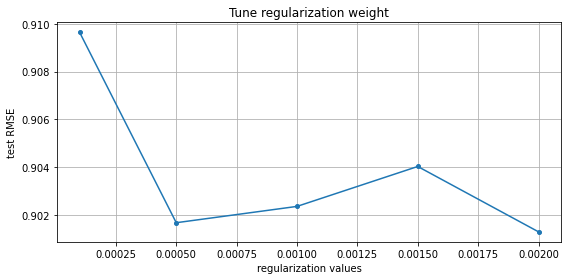

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
ax.plot(regs , y_axis, marker='.', linewidth=1.5, markersize=8)
ax.set_ylabel('test RMSE')
ax.set_xlabel('regularization values')
ax.set_title('Tune regularization weight')
ax.grid(True)
plt.tight_layout()
plt.show()

Based on this plot, what is the best regularization weight for your MF model?


0.002

## Improve the Model

Next, you need to try your best to improve the model so that we can improve our RMSE! This is open-ended, so feel free to try whatever tricks you like. We talked about several in class, plus you can find more in the readings. Write your code in the next cell and print out the RMSE of your new model.

In [ ]:
# implement your improved model and print out the RMSE
# Your Code Here...

class MF_modified:
    def __init__(self, train_mat, test_mat, latent=5, lr=0.01, reg=0.01):
        self.train_mat = train_mat  # the training rating matrix of size (#user, #movie)
        self.test_mat = test_mat  # the training rating matrix of size (#user, #movie)

        self.latent = latent  # the latent dimension
        self.lr = lr  # learning rate
        self.reg = reg  # regularization weight, i.e., the lambda in the objective function

        self.num_user, self.num_movie = train_mat.shape

        self.sample_user, self.sample_movie = self.train_mat.nonzero()  # get the user-movie paris having ratings in train_mat
        self.num_sample = len(self.sample_user)  # the number of user-movie pairs having ratings in train_mat

        self.train_indicator_mat = 1.0 * (train_mat > 0)  # binary matrix to indicate whether s user-movie pair has rating or not in train_mat
        self.test_indicator_mat = 1.0 * (test_mat > 0)  # binary matrix to indicate whether s user-movie pair has rating or not in test_mat

        self.P = np.random.random((self.num_user, self.latent))  # latent factors for users, size (#user, self.latent), randomly initialized
        self.Q = np.random.random((self.num_movie, self.latent))  # latent factors for users, size (#movie, self.latent), randomly initialized

        self.user_bias = np.random.random(self.num_user)
        self.movie_bias = np.random.random(self.num_movie)

        self.overall_mean = overall_mean

    def train(self, epoch=20, verbose=True):
        """
        Goal: Write your code to train your matrix factorization model for epoch iterations in this function
        Input: epoch -- the number of training epoch
        Output: epoch_loss_list -- a list recording the training loss for each epoch
                epoch_test_RMSE_list -- a list recording the testing RMSE after each training epoch
        """
        epoch_loss_list = []
        epoch_RMSE_list = []
        self.user_ids,self.movie_ids=self.train_mat.nonzero()


        indices = np.arange(len(self.user_ids))
        for ep in range(epoch):
            """
            Write your code here to implement the training process for one epoch,
            and at the end of each epoch, print out the epoch number, the training loss after this epoch,
            and the test RMSE after this epoch
            """
            temp=np.copy(indices)
            np.random.shuffle(temp)
            for i in temp:
              user = self.user_ids[i]
              movie=self.movie_ids[i]

              bias = overall_mean + self.user_bias[user] + self.movie_bias[movie]
              self.P[user]-=self.lr*(2* (self.P[user].dot(self.Q[movie].T) + bias - self.train_mat[user][movie])  * self.Q[movie] + 2*self.reg*self.P[user] )
              self.Q[movie]-= self.lr*(2* (self.P[user].dot(self.Q[movie].T) + bias - self.train_mat[user][movie])  * self.P[user] + 2*self.reg*self.Q[movie] )

              self.user_bias[user]-=self.lr*(2* (self.P[user].dot(self.Q[movie].T) + bias - self.train_mat[user][movie]) + 2*self.reg*(self.user_bias[user]) )
              self.movie_bias[movie]-=self.lr*(2* (self.P[user].dot(self.Q[movie].T) + bias - self.train_mat[user][movie]) + 2*self.reg*(self.movie_bias[movie]))

            user_ids,movie_ids=self.train_mat.nonzero()
            loss=0.0
            for i in range(0,len(self.user_ids)):
              user = self.user_ids[i]
              movie=self.movie_ids[i]

              bias = overall_mean + self.user_bias[user] + self.movie_bias[movie]

              loss += np.square( np.dot(self.P[user],self.Q[movie].T) + bias - train_mat[user][movie] )
            #loss += self.reg * (np.sum(self.P ** 2) + np.sum(self.Q ** 2) + np.sum(self.user_bias ** 2) + np.sum(self.movie_bias ** 2 ) )

            loss = loss + self.reg*(np.square(np.linalg.norm(self.P,'fro'))+np.square(np.linalg.norm(self.Q,'fro')) + np.square(np.linalg.norm(self.user_bias)) + np.square(np.linalg.norm(self.movie_bias)))
            epoch_loss_list.append(loss)


            rmse = 0.0
            count=0.0

            user_ids,movie_ids=self.test_mat.nonzero()
            for i in range(0,len(user_ids)):
              user = user_ids[i]
              movie = movie_ids[i]

              bias = overall_mean + self.user_bias[user] + self.movie_bias[movie]

              rmse += np.square( np.dot(self.P[user],self.Q[movie].T) + bias -test_mat[user][movie])
              count+=1

            rmse = np.sqrt(rmse / count)

            print("Epoch {} : loss = {} , rmse = {}".format(ep+1,loss,rmse))
            epoch_RMSE_list.append(rmse)



            """
            End of your code for this function
            """
        return epoch_loss_list, epoch_RMSE_list


    def predict(self):
        prediction_mat = np.matmul(self.P, self.Q.T)
        return prediction_mat

In [ ]:
import math
mf = MF_modified(train_mat, test_mat, latent=4, lr=0.01, reg=0.0005)
epoch_loss_list, epoch_test_RMSE_list = mf.train(epoch=20)
print("loss for 20 epochs: ")
print(epoch_loss_list)
print("rmse for 20 epochs: ")
print(epoch_test_RMSE_list)

loss: 9438237.022307253, rmse: 0.9434893632567722
loss: 9350037.210583655, rmse: 0.925432693190332
loss: 9333923.079315914, rmse: 0.9199567717566584
loss: 9324049.789917545, rmse: 0.9122981504152224
loss: 9359430.620867534, rmse: 0.903234557214911
loss: 9372528.743765224, rmse: 0.8973275500958287
loss: 9399820.838529784, rmse: 0.8929230078783399
loss: 9414739.5288205, rmse: 0.8904309187340224
loss: 9400462.205194633, rmse: 0.8882593815482384
loss: 9393734.863639733, rmse: 0.8883838255426644
loss: 9391790.395323781, rmse: 0.8876957488351542
loss: 9398484.614880228, rmse: 0.8871527350000343
loss: 9393093.894736443, rmse: 0.8873076145256764
loss: 9427202.810335344, rmse: 0.8878779076023053
loss: 9427329.292985164, rmse: 0.8884063512687438
loss: 9391204.83861061, rmse: 0.8890937054910478
loss: 9425333.482512647, rmse: 0.8908676132758594
loss: 9404526.419843508, rmse: 0.8916683876232177
loss: 9405724.620738028, rmse: 0.8927170918146021
loss: 9411031.09044967, rmse: 0.8938678114729123
loss f

In [ ]:
import math
mf = MF_modified(train_mat, test_mat, latent=4, lr=0.01, reg=0.002)
epoch_loss_list, epoch_test_RMSE_list = mf.train(epoch=20)

Epoch 1 : loss = 598370.3895762174 , rmse = 0.9443114525658064
Epoch 2 : loss = 566373.690667424 , rmse = 0.9247811243523975
Epoch 3 : loss = 548442.864243782 , rmse = 0.9164048561547571
Epoch 4 : loss = 528432.2866897485 , rmse = 0.9066622861633271
Epoch 5 : loss = 513481.75680735544 , rmse = 0.8994659675345581
Epoch 6 : loss = 503561.6918917885 , rmse = 0.8949140560917408
Epoch 7 : loss = 495977.8625992246 , rmse = 0.8919542200418472
Epoch 8 : loss = 490472.13362762675 , rmse = 0.89041426803634
Epoch 9 : loss = 486216.59085244936 , rmse = 0.8894012006731994
Epoch 10 : loss = 483657.08420980314 , rmse = 0.8888063700486126
Epoch 11 : loss = 480247.4090571604 , rmse = 0.8879490623735417
Epoch 12 : loss = 478665.4524296225 , rmse = 0.8876422653629985
Epoch 13 : loss = 476665.6383468526 , rmse = 0.8869198511954073
Epoch 14 : loss = 476370.5347436142 , rmse = 0.8881890157493023
Epoch 15 : loss = 474280.0222056195 , rmse = 0.8874685748267862
Epoch 16 : loss = 474122.3700474144 , rmse = 0.88

And please briefly explain what your new model does to improve the performance.

I tried to add bias to the prediction to improve the MF model performance. Performance improved from 0.90 to 0.89.